#Train

In [ ]:
import pandas as pd
import os
df= pd.read_csv("full_data_imputed.csv",index_col=False)
df.columns
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df.columns

Index(['Local Time', 'Aqi', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2',
       'Train Name', 'Clouds', 'Precipitation', 'Pressure',
       'Relative Humidity', 'Temperature', 'UV_Index', 'Wind Speed',
       'Latitude', 'Longitude'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df_copy = df.copy()
df_copy['Local Time'] = pd.to_datetime(df_copy['Local Time'])
print(df_copy.isnull().sum())

# Giả sử df_copy đã có sẵn
df_copy = df_copy.set_index('Local Time')
weather_cols = ['Clouds', 'Precipitation', 'Pressure',
                'Relative Humidity', 'Temperature', 'UV_Index', 'Wind Speed']

df_copy[weather_cols] = df_copy[weather_cols].ffill().bfill()

# Encode train name
# le = LabelEncoder()
# df_copy['Train Name'] = le.fit_transform(df_copy['Train Name'])
df_copy['Month']=df_copy.index.month # Access month from index
df_copy['Day']=df_copy.index.day # Access day from index
df_copy['Hour']=df_copy.index.hour # Access hour from index
df_copy['Weekday']=df_copy.index.weekday # Access weekday from index
df_copy.drop('Latitude',axis=1,inplace=True)
df_copy.drop('Longitude',axis=1,inplace=True)


# ===============================
# 3️⃣ Chia train/val/test theo năm
# ===============================
train_data = df_copy.loc['2023':'2024']
val_data   = df_copy.loc['2025-01':'2025-06']
test_data  = df_copy.loc['2025-07':'2025-09']

target_col = 'Aqi'
X_train, y_train = train_data.drop(columns=[target_col]), train_data[target_col]
X_val, y_val     = val_data.drop(columns=[target_col]), val_data[target_col]
X_test, y_test   = test_data.drop(columns=[target_col]), test_data[target_col]

# ===============================
# 4️⃣ Scale dữ liệu
# ===============================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

Local Time           0
Aqi                  0
Co                   0
No2                  0
O3                   0
Pm10                 0
Pm25                 0
So2                  0
Train Name           0
Clouds               0
Precipitation        0
Pressure             0
Relative Humidity    0
Temperature          0
UV_Index             0
Wind Speed           0
Latitude             0
Longitude            0
dtype: int64


In [ ]:
#Print shape data
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(685464, 18)
(169686, 18)
(86283, 18)


In [ ]:
# ===============================
# 5️⃣ Tạo dataset cho LSTM
# ===============================
import tensorflow as tf # Import TensorFlow here

length = 24  # 1 ngày
batch_size = 32
n_features = X_train_scaled.shape[1]

train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train_scaled, targets=y_train_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val_scaled, targets=y_val_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test_scaled, targets=y_test_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

In [ ]:
# ===============================
# 6️⃣ Custom metrics
# ===============================
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GRU, Dense, Dropout # Import GRU here

def rmsle_custom(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return tf.sqrt(msle(y_true, y_pred))

def r2_keras(y_true, y_pred):
    # Cast y_pred to the same data type as y_true
    y_pred = tf.cast(y_pred, y_true.dtype)
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# ===============================
# 7️⃣ Model LSTM
# ===============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
# First GRU layer with Dropout regularisation
model.add(GRU(units=50, return_sequences=True, input_shape=(length, n_features), activation='tanh')) # Corrected input_shape
model.add(Dropout(0.2))
# Second GRU layer
model.add(GRU(units=50, return_sequences=True, activation='tanh')) # Removed input_shape for subsequent layers
model.add(Dropout(0.2))
# Third GRU layer
model.add(GRU(units=50, return_sequences=True, activation='tanh')) # Removed input_shape for subsequent layers
model.add(Dropout(0.2))
# Fourth GRU layer
model.add(GRU(units=50, activation='tanh')) # Removed input_shape for subsequent layers
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[
        rmsle_custom,
        'mae',
        'mse',
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        'mape',
        'msle',
        r2_keras
    ]
)

# ===============================
# 8️⃣ Callbacks
# ===============================
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3,
    verbose=1, min_lr=1e-6
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# ===============================
# 8️⃣ Train model
# ===============================
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[es, plateau],
    verbose=1
)


Epoch 1/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 395s 18ms/step - loss: 0.0710 - mae: 0.1657 - mape: 114.5676 - mse: 0.0710 - msle: 0.0120 - r2_keras: -2.2913 - rmse: 0.2637 - rmsle_custom: 0.0431 - val_loss: 0.0517 - val_mae: 0.1770 - val_mape: 183.0067 - val_mse: 0.0517 - val_msle: 0.0098 - val_r2_keras: -0.7498 - val_rmse: 0.2273 - val_rmsle_custom: 0.0656 - learning_rate: 0.0010
Epoch 2/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 395s 18ms/step - loss: 0.0212 - mae: 0.0942 - mape: 63.2576 - mse: 0.0212 - msle: 0.0024 - r2_keras: -0.3246 - rmse: 0.1450 - rmsle_custom: 0.0235 - val_loss: 0.0333 - val_mae: 0.1440 - val_mape: 158.5449 - val_mse: 0.0333 - val_msle: 0.0068 - val_r2_keras: -0.3640 - val_rmse: 0.1825 - val_rmsle_custom: 0.0544 - learning_rate: 0.0010
Epoch 3/50
21421/21421 ━━━━━━━━━━━━━━━━━━━━ 394s 18ms/step - loss: 0.0144 - mae: 0.0766 - mape: 47.9129 - mse: 0.0144 - msle: 0.0015 - r2_keras: 0.1816 - rmse: 0.1196 - rmsle_custom: 0.0199 - val_loss: 0.0259 - val_mae: 0.1282 - val_mape: 

In [ ]:
import matplotlib.pyplot as plt

def plot_all_losses(hist):
    """
    Vẽ tất cả các loss và metric (train/val) trong history của model.
    """
    # Lấy tất cả key trong history
    keys = list(hist.history.keys())

    # Chỉ lấy các metric chính (bỏ qua val_)
    main_metrics = [k for k in keys if not k.startswith('val_')]

    for key in main_metrics:
        # Bỏ qua các metric không cần thiết
        if any(metric in key for metric in [
            'loss', 'mae', 'mse', 'rmse', 'rmsle', 'r2'
        ]):
            plt.figure(figsize=(10, 6))

            # Plot train metric
            plt.plot(hist.history[key], label=f'Train {key.replace("_", " ").title()}', linewidth=2)

            # Plot val metric nếu có
            val_key = f'val_{key}'
            if val_key in hist.history:
                plt.plot(hist.history[val_key], label=f'Val {key.replace("_", " ").title()}', linestyle='--', linewidth=2)

            plt.title(f'Model {key.replace("_", " ").title()} over Epochs', fontsize=14)
            plt.xlabel('Epoch', fontsize=12)
            plt.ylabel(key.replace("_", " ").title(), fontsize=12)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

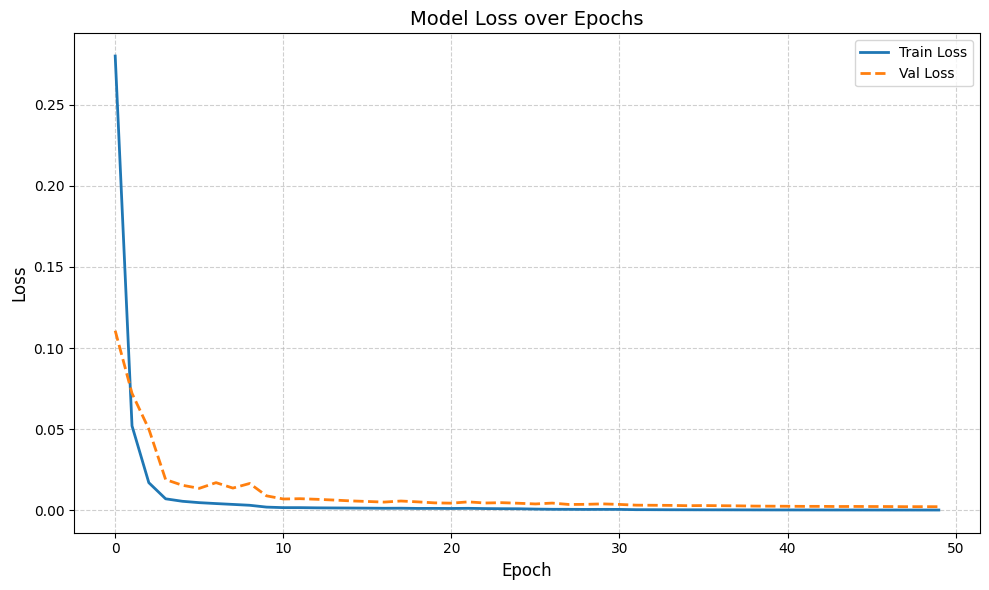

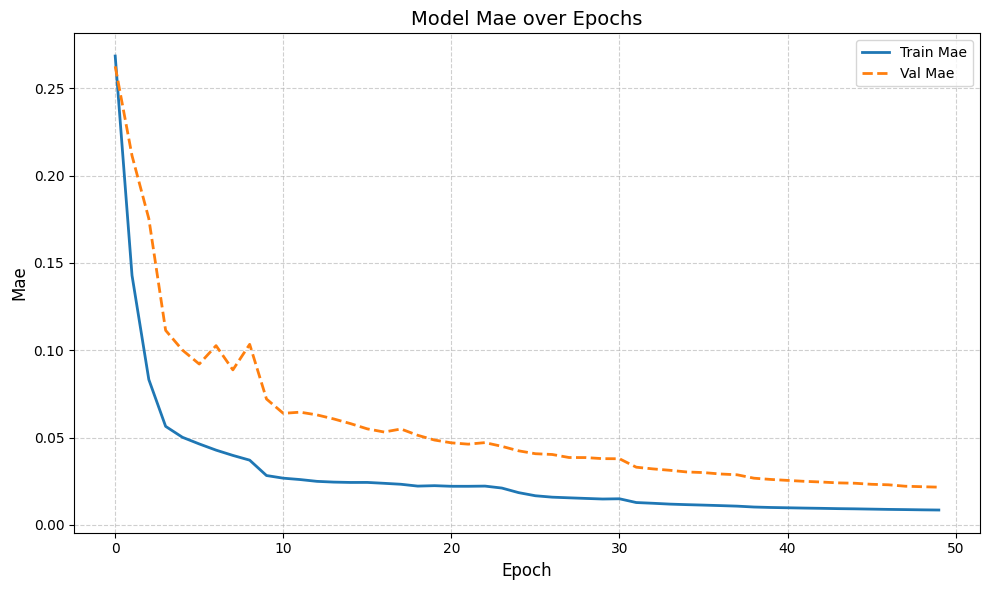

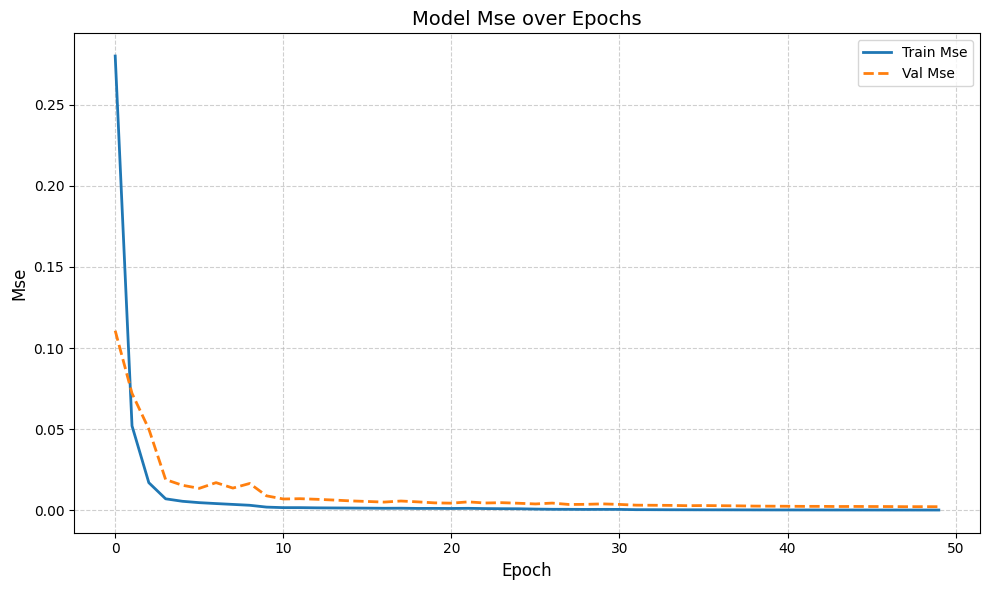

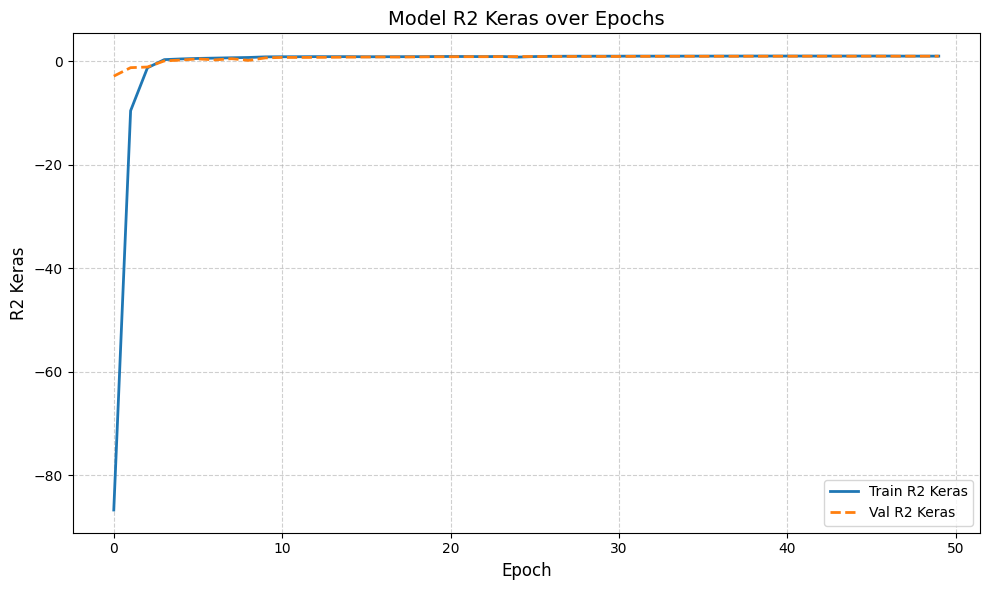

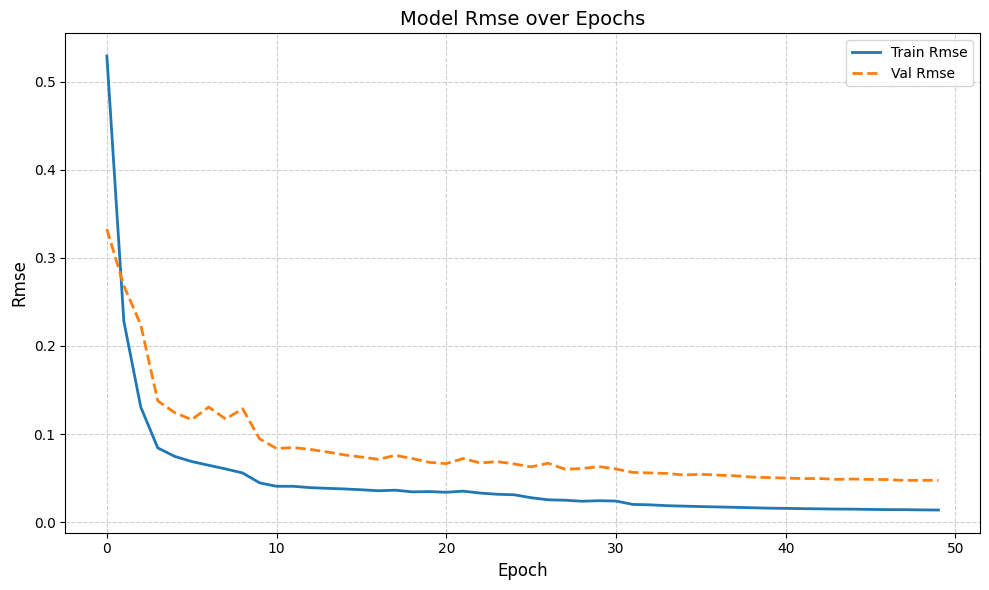

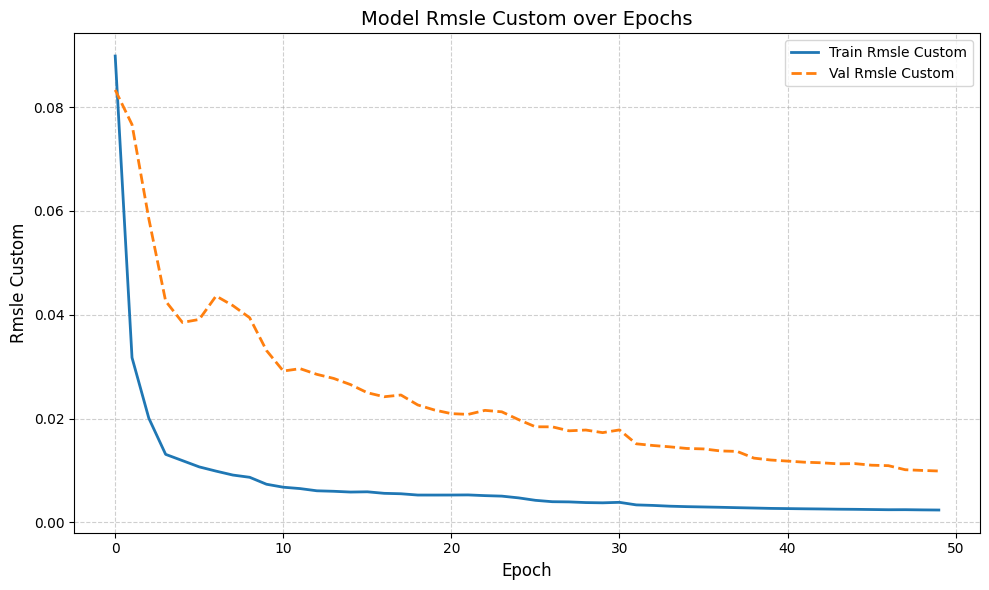

In [ ]:
plot_all_losses(hist)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Evaluate the model on the test dataset
print("Evaluating the model on the test dataset...")
test_results = model.evaluate(test_dataset, verbose=0)

# Extract metrics
test_loss = test_results[0]
test_rmsle = test_results[1]
test_mae = test_results[2]
test_mse = test_results[3]
test_rmse = test_results[4]
test_mape = test_results[5]
test_msle = test_results[6]
test_r2 = test_results[7]

Evaluating the model on the test dataset...


In [ ]:
#Print
print(f"Test Loss: {test_loss}")
print(f"Test RMSLE: {test_rmsle}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAPE: {test_mape}")
print(f"Test MSLE: {test_msle}")
print(f"Test R2: {test_r2}")

Test Loss: 0.024293523281812668
Test RMSLE: 0.014583573676645756
Test MAE: 0.0574195422232151
Test MSE: 0.024293523281812668
Test RMSE: 0.15586379170417786
Test MAPE: 28.09951400756836
Test MSLE: 0.0021858911495655775
Test R2: -26.811830520629883


In [ ]:
def save_lstm_model(model, model_name="lstm_model"):
    """
    Saves the trained LSTM model to Google Drive.

    Args:
        model: The trained Keras model object.
        model_name (str): The base name for the saved model file (without extension).
    """
    # Define the path to save the model
    model_save_path =model_name+".h5"

    print(f"Saving the model to: {model_save_path}")
    model.save(model_save_path)
    print("Model saved successfully!")

# Call the function to save the model
save_lstm_model(model, "lstm")

Saving the model to: lstm.h5
Model saved successfully!


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate metrics
y_hat_test=model.predict(test_dataset)
y_hat_test_inv = scaler_y.inverse_transform(y_hat_test)
y_test_inv = scaler_y.inverse_transform(y_test_scaled[:len(y_hat_test)])

2696/2696 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from tensorflow.keras.metrics import MeanSquaredLogarithmicError

def evaluate_and_print_metrics(y_true_inv, y_hat_inv, X_test_scaled):
    """
    Calculates and prints various evaluation metrics.

    Args:
        y_true_inv (np.ndarray): The inverse-scaled true values.
        y_hat_inv (np.ndarray): The inverse-scaled predicted values.
        X_test_scaled (np.ndarray): The scaled test features (used for adjusted R-squared).
    """
    # Calculate R-squared
    r2 = r2_score(y_true_inv, y_hat_inv)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true_inv, y_hat_inv)

    #MSE
    mse = mean_squared_error(y_true_inv, y_hat_inv)

    #RMSE
    rmse = np.sqrt(mse)

    #MSLE
    msle_metric = MeanSquaredLogarithmicError()
    msle = msle_metric(y_true_inv, y_hat_inv).numpy() # Calculate MSLE using the Keras metric

    # Calculate Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero in MAPE calculation
    mape = np.mean(np.abs((y_true_inv - y_hat_inv) / (y_true_inv + 1e-8))) * 100


    # Calculate Adjusted R-squared
    n = len(y_true_inv)
    p = X_test_scaled.shape[1] # Use the number of features from the scaled data
    # Ensure n > p + 1 for adjusted R-squared calculation
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adjusted_r2 = np.nan # Cannot calculate adjusted R-squared

    print(f"Test Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MSLE: {msle:.4f}")
    # RMSLE can be calculated from MSLE
    rmsle = np.sqrt(msle)
    print(f"  RMSLE: {rmsle:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R-squared: {r2:.4f}")
    print(f"  Adjusted R-squared: {adjusted_r2:.4f}")

In [ ]:
#Call
evaluate_and_print_metrics(y_test_inv, y_hat_test_inv, X_test_scaled)

Test Metrics:
  MAE: 6.7147
  MSE: 332.2190
  RMSE: 18.2269
  MSLE: 0.1108
  RMSLE: 0.3329
  MAPE: 12.8251
  R-squared: 0.6491
  Adjusted R-squared: 0.6490


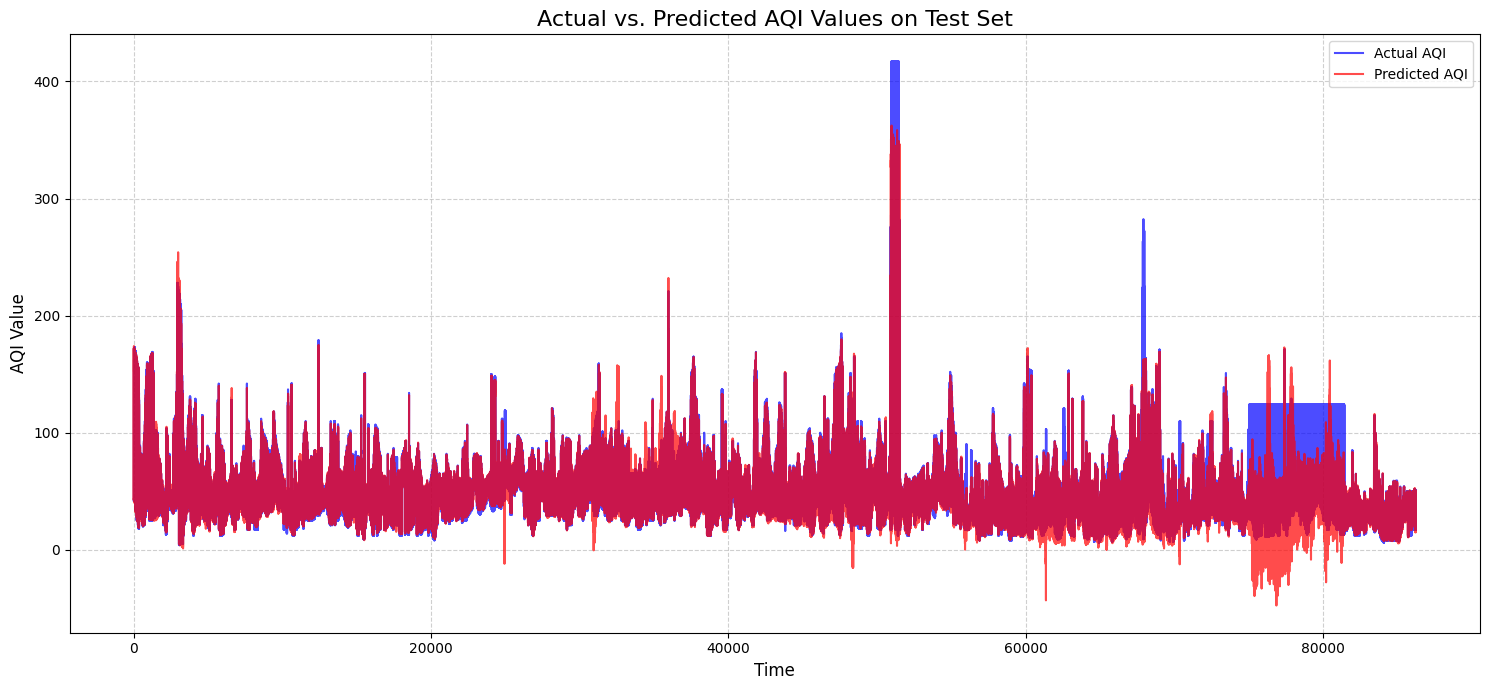

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes for the plot
plt.figure(figsize=(15, 7))

# Plot the actual test values
plt.plot(y_test_inv, label='Actual AQI', color='blue', alpha=0.7)

# Plot the predicted values
# Ensure y_hat_test_inv has the same length as y_test_inv for plotting
plt.plot(y_hat_test_inv, label='Predicted AQI', color='red', alpha=0.7)

# Add title and labels
plt.title('Actual vs. Predicted AQI Values on Test Set', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

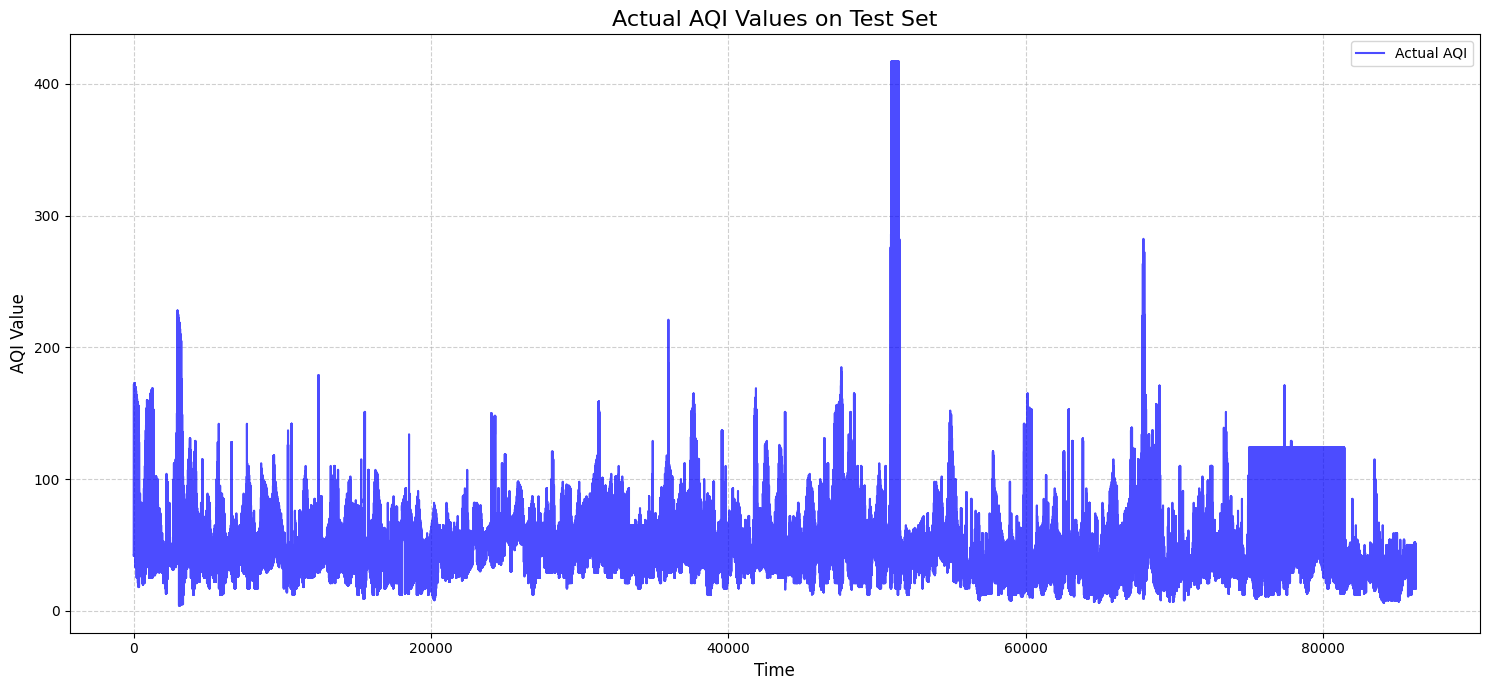

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes for the plot
plt.figure(figsize=(15, 7))

# Plot the actual test values
plt.plot(y_test_inv, label='Actual AQI', color='blue', alpha=0.7)

# Add title and labels
plt.title('Actual AQI Values on Test Set', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

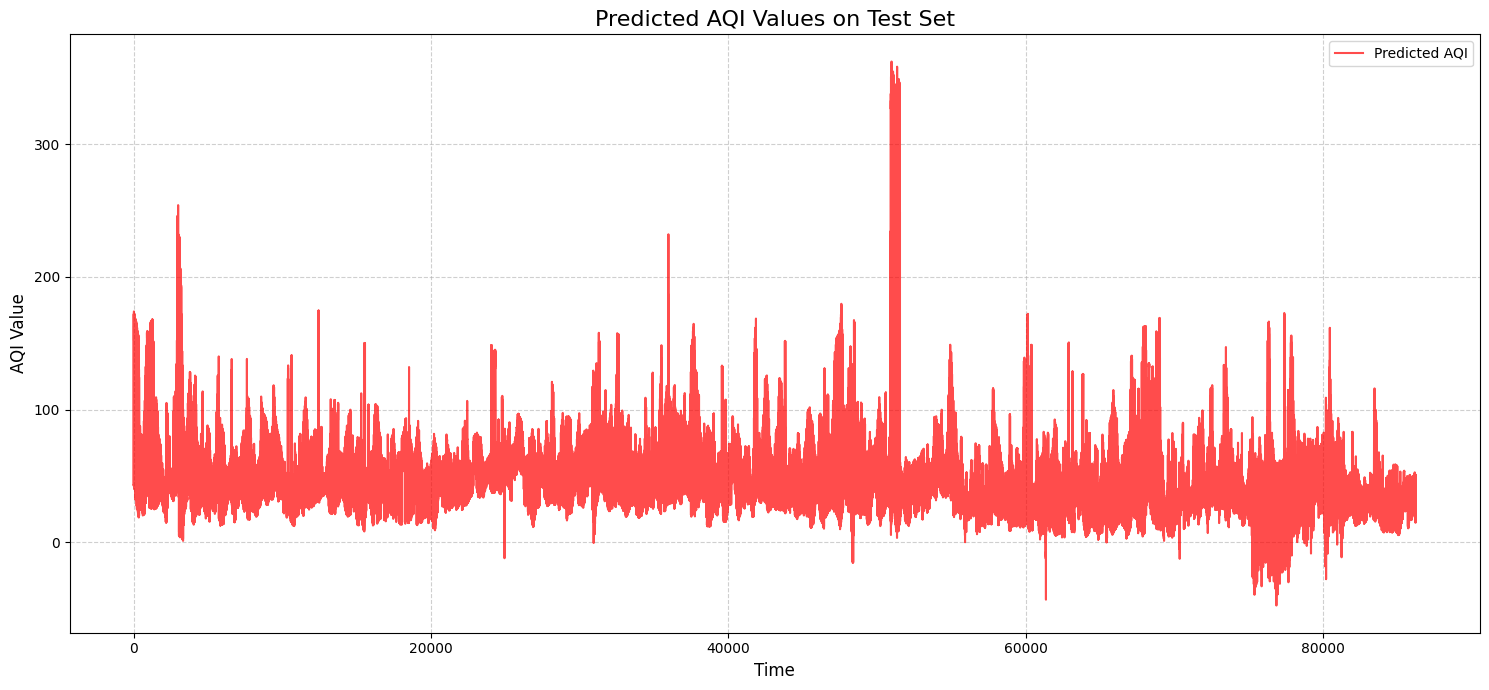

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes for the plot
plt.figure(figsize=(15, 7))

# Plot the predicted values
plt.plot(y_hat_test_inv, label='Predicted AQI', color='red', alpha=0.7)

# Add title and labels
plt.title('Predicted AQI Values on Test Set', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# Task
Implement a CNN-LSTM model for Air Quality Index (AQI) prediction using the provided data, which includes both static (latitude, longitude) and dynamic (meteorological factors, pollutant concentrations) environmental covariates. The model should leverage CNNs for spatial feature extraction from location data and LSTMs for temporal feature extraction from time-series data. Train and evaluate the model, then visualize the predictions against the actual values.

In [8]:
# ===============================
# 5️⃣ Tạo dataset cho LSTM
# ===============================
import tensorflow as tf # Import TensorFlow here

length = 24  # 1 ngày
batch_size = 32
n_features = X_train_scaled.shape[1]

# Create time series datasets
train_dataset_ts = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train_scaled, targets=y_train_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

val_dataset_ts = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val_scaled, targets=y_val_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

test_dataset_ts = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test_scaled, targets=y_test_scaled,
    sequence_length=length, batch_size=batch_size,
    shuffle=False)

# Prepare spatial datasets to match the time series datasets
# We need to align the spatial data with the sequences created by timeseries_dataset_from_array
# This means for each sequence of length 'length', we need the corresponding spatial data point.
# Since spatial data is static for a location, we can just repeat the spatial data for each step in the sequence.

# First, get the indices from the time series datasets to align the spatial data
train_indices = list(train_dataset_ts.map(lambda x, y: x).unbatch().map(lambda x: x[0]).as_numpy_iterator())
val_indices = list(val_dataset_ts.map(lambda x, y: x).unbatch().map(lambda x: x[0]).as_numpy_iterator())
test_indices = list(test_dataset_ts.map(lambda x, y: x).unbatch().map(lambda x: x[0]).as_numpy_iterator())

# Due to the way timeseries_dataset_from_array creates sequences, the number of sequences is
# len(data) - sequence_length + 1. We need to align the spatial data accordingly.

train_spatial_aligned = train_spatial_scaled[length - 1:]
val_spatial_aligned = val_spatial_scaled[length - 1:]
test_spatial_aligned = test_spatial_scaled[length - 1:]


# Create spatial datasets. We will zip the time series datasets with the spatial data later for training.
train_dataset_spatial = tf.data.Dataset.from_tensor_slices(train_spatial_aligned).batch(batch_size)
val_dataset_spatial = tf.data.Dataset.from_tensor_slices(val_spatial_aligned).batch(batch_size)
test_dataset_spatial = tf.data.Dataset.from_tensor_slices(test_spatial_aligned).batch(batch_size)


# Combine the time series and spatial datasets
train_dataset_cnn_lstm = tf.data.Dataset.zip((train_dataset_ts, train_dataset_spatial)).map(lambda ts, spatial: ((ts[0], spatial), ts[1]))
val_dataset_cnn_lstm = tf.data.Dataset.zip((val_dataset_ts, val_dataset_spatial)).map(lambda ts, spatial: ((ts[0], spatial), ts[1]))
test_dataset_cnn_lstm = tf.data.Dataset.zip((test_dataset_ts, test_dataset_spatial)).map(lambda ts, spatial: ((ts[0], spatial), ts[1]))

Exception ignored in: <function Executor.__del__ at 0x785dc684d440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/eager/executor.py", line 47, in __del__
    pywrap_tfe.TFE_DeleteExecutor(self._handle)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [7]:
# ===============================
# 2️⃣ Define the CNN-LSTM Model
# ===============================
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Input, concatenate
from tensorflow.keras.models import Model

# Define the input shape for the time series data
time_series_input_shape = (length, X_train_scaled.shape[1]) # length is defined in a previous cell
# Define the input shape for the spatial data
spatial_input_shape = (train_spatial_scaled.shape[1], 1) # Assuming 2 spatial features (Lat, Lon)

# Time Series Branch (LSTM)
time_series_input = Input(shape=time_series_input_shape, name='time_series_input')
lstm_layer = LSTM(units=50, return_sequences=True, activation='tanh')(time_series_input)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_layer = LSTM(units=50, return_sequences=True, activation='tanh')(lstm_layer)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_layer = LSTM(units=50, activation='tanh')(lstm_layer)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_output = Dense(units=32, activation='relu')(lstm_layer) # Reduced dense units before concatenation

# Spatial Branch (CNN)
spatial_input = Input(shape=spatial_input_shape, name='spatial_input')
# Reshape spatial input for Conv1D (batch_size, steps, channels)
# Here, steps would be the number of spatial features (2: Lat, Lon) and channels is 1
cnn_layer = Conv1D(filters=32, kernel_size=1, activation='relu')(spatial_input) # Kernel size 1 as we have only 2 steps
cnn_layer = MaxPooling1D(pool_size=1)(cnn_layer) # Pool size 1 as we have only 2 steps
cnn_layer = Flatten()(cnn_layer)
cnn_output = Dense(units=16, activation='relu')(cnn_layer) # Reduced dense units

# Combine Branches
combined_input = concatenate([lstm_output, cnn_output])

# Fully Connected Layers
dense_layer = Dense(units=32, activation='relu')(combined_input) # Adjusted dense units
dense_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(units=1, activation='linear')(dense_layer) # Output for regression

# Create the model
model = Model(inputs=[time_series_input, spatial_input], outputs=output_layer)

# Print the model summary
model.summary()

NameError: name 'length' is not defined

In [5]:
import pandas as pd
import os

df = pd.read_csv("full_data_imputed.csv", index_col=False)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df_copy = df.copy()
df_copy['Local Time'] = pd.to_datetime(df_copy['Local Time'])
print(df_copy.isnull().sum())

# Giả sử df_copy đã có sẵn
df_copy = df_copy.set_index('Local Time')
weather_cols = ['Clouds', 'Precipitation', 'Pressure',
                'Relative Humidity', 'Temperature', 'UV_Index', 'Wind Speed']

df_copy[weather_cols] = df_copy[weather_cols].ffill().bfill()

# Encode train name
# le = LabelEncoder()
# df_copy['Train Name'] = le.fit_transform(df_copy['Train Name'])
df_copy['Month']=df_copy.index.month # Access month from index
df_copy['Day']=df_copy.index.day # Access day from index
df_copy['Hour']=df_copy.index.hour # Access hour from index
df_copy['Weekday']=df_copy.index.weekday # Access weekday from index

# Keep Latitude and Longitude for CNN input
spatial_cols = ['Latitude', 'Longitude']
spatial_data = df_copy[spatial_cols]
df_copy.drop(['Latitude', 'Longitude'], axis=1, inplace=True)


# ===============================
# 3️⃣ Chia train/val/test theo năm
# ===============================
train_data = df_copy.loc['2023':'2024']
val_data   = df_copy.loc['2025-01':'2025-06']
test_data  = df_copy.loc['2025-07':'2025-09']

# Split spatial data accordingly
train_spatial = spatial_data.loc[train_data.index]
val_spatial   = spatial_data.loc[val_data.index]
test_spatial  = spatial_data.loc[test_data.index]


target_col = 'Aqi'
X_train, y_train = train_data.drop(columns=[target_col]), train_data[target_col]
X_val, y_val     = val_data.drop(columns=[target_col]), val_data[target_col]
X_test, y_test   = test_data.drop(columns=[target_col]), test_data[target_col]


# ===============================
# 4️⃣ Scale dữ liệu
# ===============================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

# Scale spatial data (optional, depending on CNN input requirements)
# For a simple CNN on Lat/Lon, scaling might not be strictly necessary,
# but it's good practice.
scaler_spatial = StandardScaler()
train_spatial_scaled = scaler_spatial.fit_transform(train_spatial)
val_spatial_scaled   = scaler_spatial.transform(val_spatial)
test_spatial_scaled  = scaler_spatial.transform(test_spatial)


scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

Local Time           0
Aqi                  0
Co                   0
No2                  0
O3                   0
Pm10                 0
Pm25                 0
So2                  0
Train Name           0
Clouds               0
Precipitation        0
Pressure             0
Relative Humidity    0
Temperature          0
UV_Index             0
Wind Speed           0
Latitude             0
Longitude            0
dtype: int64


In [3]:
# ===============================
# 1️⃣ Prepare Data for CNN
# ===============================
# Assuming the spatial data (Latitude and Longitude) was kept in df_copy before dropping

# We need to identify the spatial columns in the original df_copy before scaling and splitting
# Let's assume 'Latitude' and 'Longitude' are still available or can be re-extracted/re-aligned

# For demonstration purposes, let's assume we have a way to get the spatial data
# aligned with the time series data. A simple approach for this dataset
# might be to consider each 'Train Name' as a distinct spatial location,
# although a more sophisticated approach would be needed for true spatial grids.

# Given the current data structure, where Latitude and Longitude were dropped
# after creating time-series datasets, we need to rethink how to incorporate spatial data.

# A common approach for CNN-LSTM on time-series with static spatial features
# is to treat the spatial features as an additional channel or input to the model.
# However, CNNs typically work on grid-like structures (images).
# If 'Train Name' represents different locations, we might one-hot encode it
# and treat it as a categorical feature, or embed it. This doesn't fit the typical
# use case of a CNN for spatial feature extraction on a grid.

# A more appropriate approach given the data might be to have two separate inputs
# to the model: one time-series input for the LSTM and one static input (e.g., one-hot encoded train name or learned embedding) that gets combined later.
# However, the task description explicitly asks for CNN for spatial feature extraction
# from location data (latitude, longitude). This implies a different data structure
# might be more suitable, perhaps treating different locations as different spatial points
# in a grid or using a graph neural network if the spatial relationships are complex.

# Given the current data format (time series data where spatial columns were dropped),
# implementing a standard CNN for spatial feature extraction as described in the task
# is not straightforward without restructuring the data significantly.

# If we strictly follow the task and assume latitude and longitude are spatial "features"
# that a CNN should process, we might need to reshape the input to have a spatial dimension.
# However, a 1D sequence of (latitude, longitude) pairs over time doesn't form a 2D grid
# that a standard 2D CNN is designed for. A 1D CNN could potentially process sequences
# of spatial features over time, but that's different from spatial feature extraction
# from a spatial grid.

# Let's assume, for the sake of demonstrating a CNN-LSTM structure as requested,
# that we can somehow create a "spatial" representation from the location data
# that a CNN can process. Without a clear spatial grid structure in the current data,
# this is a challenge.

# ************* IMPORTANT CONSIDERATION *************
# The current data preparation (time-series_dataset_from_array) is designed
# for sequence-to-one or sequence-to-sequence prediction using only the
# time-series features. The spatial features (Latitude, Longitude) were dropped
# before this step. To use them with a CNN alongside the time-series data
# with an LSTM, we would need a multi-input model.

# To proceed with the CNN-LSTM as described, we would typically need:
# 1. A time series input (X_train_scaled, X_val_scaled, X_test_scaled) for the LSTM.
# 2. A spatial input (e.g., a representation of the location) for the CNN.

# Let's modify the data preparation step to keep Latitude and Longitude
# and create a separate input for the CNN part.
# This will require re-running the data splitting and scaling.

# Let's revisit the data preparation step (Cell Nv6Y2RjPACda) to keep Latitude and Longitude
# and create separate inputs for the CNN and LSTM.

print("Rethinking data preparation for CNN-LSTM...")
print("Need to modify previous data processing steps to keep Latitude and Longitude.")

# We will generate new cells to redefine the data processing for a multi-input model.
# This cell is a placeholder to indicate the need for data preparation adjustment.

Rethinking data preparation for CNN-LSTM...
Need to modify previous data processing steps to keep Latitude and Longitude.
